In [8]:
import torch
import torch.nn.functional as F

def get_depth_from_keypoints_torch(keypoints_2d, depth_map, image_size):
    """
    从深度图中提取关键点对应的深度值（支持batch）
    
    参数:
        keypoints_2d: (B, J, 2), 关键点坐标，单位为像素 (x, y)
        depth_map: (B, 1, H, W), 每像素深度值（可为 float32）
        image_size: (H, W), 图像尺寸
    返回:
        depth_values: (B, J), 每个关键点处的深度值
    """
    B, J, _ = keypoints_2d.shape
    H, W = image_size

    # 将 keypoints 转换为 [-1, 1] 范围内的归一化坐标（符合 grid_sample 要求）
    x = keypoints_2d[..., 0] / (W - 1) * 2 - 1
    y = keypoints_2d[..., 1] / (H - 1) * 2 - 1
    grid = torch.stack((x, y), dim=-1).unsqueeze(2)  # (B, J, 1, 2)

    # 使用 grid_sample 采样深度图
    sampled = F.grid_sample(depth_map, grid, align_corners=True, mode='bilinear')  # (B, 1, J, 1)
    depth_values = sampled.squeeze(3).squeeze(1)  # (B, J)

    return depth_values


# left view

In [2]:
import torch 
from torchvision.io import read_video

one_person, *_ = read_video("/workspace/data/vis_video/run_2/osmo_1.mp4", output_format="TCHW", pts_unit="sec")
pt_info = torch.load("/workspace/data/pt/run_2/osmo_1.pt")
print(one_person[0].shape)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([3, 1080, 1920])


In [40]:
keypoint = torch.tensor(pt_info['keypoint']["keypoint"]) * torch.tensor([one_person[0].shape[2], one_person[0].shape[1]])  # 转换为像素坐标
depths = pt_info['depth']

keypoint.shape, depths.shape

/tmp/ipykernel_798423/3208353690.py:1: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



(torch.Size([1, 360, 17, 2]), torch.Size([360, 1, 1080, 1920]))

In [54]:
keypoint[0, 100]

tensor([[  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [788.5653, 455.9564],
        [  0.0000,   0.0000],
        [833.8538, 475.4560],
        [867.1099, 454.7917],
        [801.5675, 546.3642],
        [843.0987, 511.8186],
        [736.9946, 587.3425],
        [788.1431, 533.1869],
        [957.1038, 585.0499],
        [973.9921, 574.4252],
        [874.8446, 664.0502],
        [880.5425, 655.3672],
        [921.4445, 784.7084],
        [903.3007, 770.4266]])

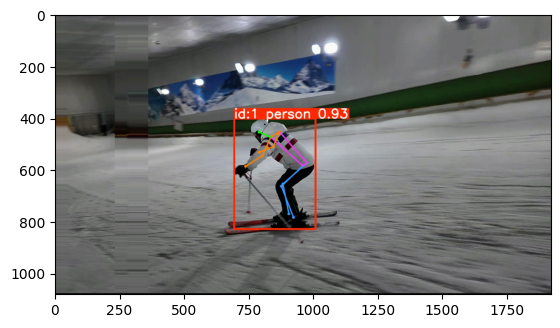

In [55]:
import matplotlib.pyplot as plt

plt.imshow(one_person[100].permute(1, 2, 0).numpy())

In [71]:

def get_depth_from_keypoints_torch(keypoints_2d, depth_map, image_size):
    """
    从深度图中提取关键点对应的深度值（支持batch）
    
    参数:
        keypoints_2d: (B, J, 2), 关键点坐标，单位为像素 (x, y)
        depth_map: (B, 1, H, W), 每像素深度值（可为 float32）
        image_size: (H, W), 图像尺寸
    返回:
        depth_values: (B, J), 每个关键点处的深度值
    """
    
    print("keypoints_2d:", keypoints_2d.shape)
    print("depth_map:", depth_map.shape)	
    
    B, J, _ = keypoints_2d.shape
    H, W = image_size

    # 将 keypoints 转换为 [-1, 1] 范围内的归一化坐标（符合 grid_sample 要求）
    x = keypoints_2d[..., 0] / (W - 1) * 2 - 1
    y = keypoints_2d[..., 1] / (H - 1) * 2 - 1
    grid = torch.stack((x, y), dim=-1).unsqueeze(2)  # (B, J, 1, 2)

    # 使用 grid_sample 采样深度图
    sampled = F.grid_sample(depth_map, grid, align_corners=True, mode='bilinear')  # (B, 1, J, 1)
    depth_values = sampled.squeeze(3).squeeze(1)  # (B, J)

    return depth_values


# 获取每个关键点的深度
depth_values = get_depth_from_keypoints_torch(keypoints_2d=keypoint[:, 100], depth_map=depths[100, :, ...].unsqueeze(0), image_size=one_person[0].shape[1:3])

print("关键点对应深度：", depth_values)

keypoints_2d: torch.Size([1, 17, 2])
depth_map: torch.Size([1, 1, 1080, 1920])
关键点对应深度： tensor([[ 4.0316,  4.0316,  4.0316, 26.7873,  4.0316, 27.1503, 27.0190, 26.8952,
         27.4095, 26.7999, 26.7345, 27.7169, 27.8665, 25.1122, 25.2160, 25.4178,
         25.2043]])


In [60]:
depth_values.shape

torch.Size([1, 17])

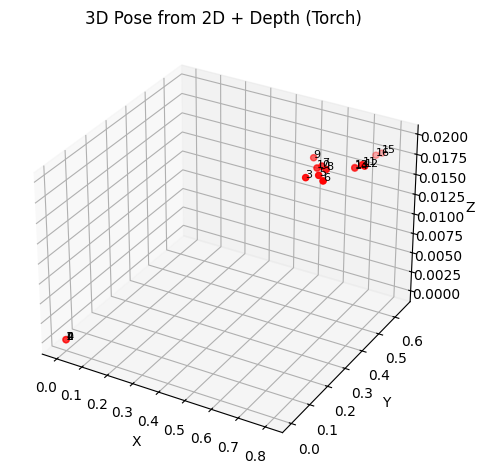

In [77]:
import torch
import matplotlib.pyplot as plt

def build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size=(1280, 720), root_index=0):
    cx, cy = image_size[0] / 2, image_size[1] / 2
    x = keypoints_2d[:, 0] - cx
    y = keypoints_2d[:, 1] - cy
    z = relative_depth
    pose3d = torch.stack([x, y, z], dim=1)
    root = pose3d[root_index]
    pose3d_centered = pose3d - root
    scale = torch.norm(pose3d_centered, dim=1).max()
    pose3d_normalized = pose3d_centered / scale
    return pose3d_normalized

# 模拟输入
J = 17
image_size = one_person[0].shape[1:3]  # (H, W)
keypoints_2d = keypoint[0, 100] # (J, 2)
relative_depth = depth_values[0]  # (J,)

# 构建 3D
pose3d = build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size)

# 可视化
x, y, z = pose3d[:, 0].numpy(), pose3d[:, 1].numpy(), pose3d[:, 2].numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r')
for i in range(J):
    ax.text(x[i], y[i], z[i], str(i), fontsize=8)
ax.set_title("3D Pose from 2D + Depth (Torch)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


keypoints_2d: torch.Size([17, 2])
relative_depth: tensor([ 4.0316,  4.0316,  4.0316, 26.7873,  4.0316, 27.1503, 27.0190, 26.8952,
        27.4095, 26.7999, 26.7345, 27.7169, 27.8665, 25.1122, 25.2160, 25.4178,
        25.2043])


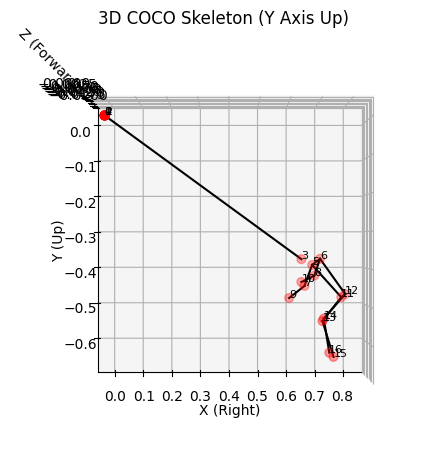

In [131]:
import plotly.graph_objects as go
import torch

def build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size=(1280, 720), root_index=0):
    cx, cy = image_size[0] / 2, image_size[1] / 2
    x = keypoints_2d[:, 0] - cx
    y = keypoints_2d[:, 1] - cy
    z = relative_depth
    pose3d = torch.stack([x, y, z], dim=1)
    root = pose3d[root_index]
    pose3d_centered = pose3d - root
    scale = torch.norm(pose3d_centered, dim=1).max()
    pose3d_normalized = pose3d_centered / scale
    return pose3d_normalized


def build_3d_pose_from_2d_and_depth_absolute(keypoints_2d, relative_depth, image_size=(1280, 720)):
    """
    使用图像中心为原点，构建真实尺度的3D姿态（不进行中心化和归一化）
    输入:
        keypoints_2d: (J, 2) 像素坐标 (u, v)
        relative_depth: (J,) 相对或绝对深度值
        image_size: (W, H) 图像大小
    输出:
        pose3d: (J, 3) 真实尺度下的 3D 坐标（单位：像素+深度单位）
    """
    cx, cy = image_size[0] / 2, image_size[1] / 2
    x = keypoints_2d[:, 0]  # X 轴向右
    y = keypoints_2d[:, 1]  # Y 轴向下
    z = relative_depth           # Z 轴向前（或深度方向）

    pose3d = torch.stack([x, y, z], dim=1)
    return pose3d

# 示例数据（你原来的）
J = 17
image_size = one_person[0].shape[1:3]  # (H, W)
keypoints_2d = keypoint[0, 100]  # shape=(J, 2)
relative_depth = depth_values[0]      # shape=(J,)
print("keypoints_2d:", keypoints_2d.shape)
print("relative_depth:", relative_depth)  

# 构建 3D
pose3d = build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size)

# 转换方向（Y 轴向上）
x = pose3d[:, 0].numpy()
y = -pose3d[:, 1].numpy()  # 注意：Y 轴翻转
z = -pose3d[:, 2].numpy()

# COCO skeleton 连接关系（骨架）
coco_skeleton = [
    (0, 1), (0, 2),
    (1, 3), (2, 4),
    (5, 6),
    (5, 7), (7, 9),
    (6, 8), (8,10),
    (5,11), (6,12),
    (11,12),
    (11,13), (13,15),
    (12,14), (14,16)
]

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 画点
ax.scatter(x, y, z, c='r', s=40)
for i in range(J):
    ax.text(x[i], y[i], z[i], str(i), fontsize=8)

# 画连线
for i, j in coco_skeleton:
    ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], c='black')

ax.view_init(elev=90, azim=-90)  # elev=仰角, azim=水平角度

# 坐标轴标签
ax.set_title("3D COCO Skeleton (Y Axis Up)")
ax.set_xlabel("X (Right)")
ax.set_ylabel("Y (Up)")
ax.set_zlabel("Z (Forward)")
plt.tight_layout()
plt.show()

In [107]:

# 提取 x, y, z
# pose3d = build_3d_pose_from_2d_and_depth_torch(keypoints_2d, relative_depth, image_size)
pose3d = build_3d_pose_from_2d_and_depth_absolute(keypoints_2d, relative_depth, image_size)

# 👉 方向调整：Y 轴向上，Z 轴向里（符合摄像机观察）
x = pose3d[:, 0].numpy()
y = -pose3d[:, 1].numpy()  # 向上
z = -pose3d[:, 2].numpy()  # 深度往里

# 👉 COCO 关键点连线结构
coco_skeleton = [
    (0, 1), (0, 2),
    (1, 3), (2, 4),
    (5, 6),
    (5, 7), (7, 9),
    (6, 8), (8,10),
    (5,11), (6,12),
    (11,12),
    (11,13), (13,15),
    (12,14), (14,16)
]

# ✅ 绘制关键点（带编号）
scatter = go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers+text',
    text=[str(i) for i in range(J)],
    marker=dict(size=5, color='red'),
    textposition="top center",
    name='keypoints'
)

# ✅ 骨架连线
lines = []
for i, j in coco_skeleton:
    if i < J and j < J:
        lines.append(go.Scatter3d(
            x=[x[i], x[j]],
            y=[y[i], y[j]],
            z=[z[i], z[j]],
            mode='lines',
            line=dict(color='black', width=3),
            showlegend=False
        ))

# ✅ 绘制图形
fig = go.Figure(data=[scatter] + lines)
fig.update_layout(
    title="3D COCO Skeleton (Y Up, Z Inward)",
    scene=dict(
        xaxis_title='X (Right)',
        yaxis_title='Y (Up)',
        zaxis_title='Z (Forward)',
        aspectmode='data'
    )
)
fig.show()